# Model comparison

In this notebook we look at the XGBoost probabilities from the _runner/job.py_ script. Specifically we compare results from cid-only, pid-only and cid/pid combined features. The idea is to show that the combination of features captures more information and therefore produces a more informed model than either cid- or pid-only, even when the individual outputs are combined.

In [13]:
%pylab inline
%autosave 25

import seaborn as sns
import random
import pickle
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors


Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


<hr>
Load data from a run where the training data was obtained using an activity score threshold > 0.02 and those activity scores were used as weights during dimension reduction but not during subsequent training for classification.
<hr>

In [2]:
df_probabilities = pd.read_csv('results.csv')
print('\nnum actives: {:,}'.format(len(df_probabilities[df_probabilities['activity']==1])))
print('num inactives: {:,}\n'.format(len(df_probabilities[df_probabilities['activity']==0])))
df_probabilities.head()


num actives: 4,531
num inactives: 14,418



,run_id,run_threshold,used_dim_red_weights,used_training_weights,cid,pid,activity,sample_activity_score,validation_weight,cid_only_predict_proba,pid_only_predict_proba,combined_predict_proba
0,0,0.02,True,False,644241,P08183,1,0.439343,0.943500,0.129476,0.816876,0.612742
1,0,0.02,True,False,644241,P08684,1,0.344675,0.470095,0.129476,0.908370,0.549259
2,0,0.02,True,False,644241,Q9Y6L6,1,0.566548,0.321783,0.129476,0.699912,0.391070
3,0,0.02,True,False,644241,P00519,1,0.388344,0.935996,0.129476,0.098042,0.039059
4,0,0.02,True,False,5279,Q9NRP7,1,0.082741,0.992717,0.013979,0.082807,0.018097


## Any correlation between probabilities?

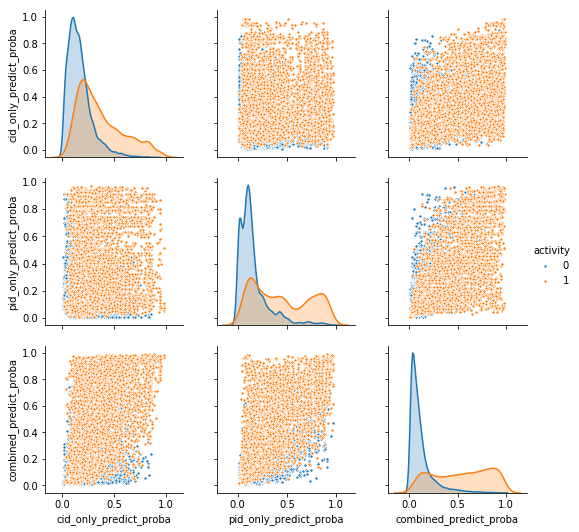

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic correlogram
cols_to_plot = ['cid_only_predict_proba', 'pid_only_predict_proba', 'combined_predict_proba']
df_in = df_probabilities[cols_to_plot+['activity']]
sns.pairplot(df_in, vars=cols_to_plot, diag_kind="kde", hue='activity', plot_kws={"s": 10})
plt.show()

## Results as May 20th and 21st, 2020

Look at results for different activity score thresholds and combinations of weights.

In [29]:
# activity scores used for both dimension reduction weights and training weights. Set using *sample_weight* property on XGBoost.
df_all_weights = pd.read_csv('05-20-2020/all_weights/params_and_metrics.csv')

# activity scores only used for dimension reduction
df_dim_red_weights = pd.read_csv('05-20-2020/dim_red_weights/params_and_metrics.csv')

# activity score only used for training
df_training_weights = pd.read_csv('05-20-2020/training_weights/params_and_metrics.csv')

# no weights used
df_no_weights = pd.read_csv('05-20-2020/no_weights/params_and_metrics.csv')

assert(len(df_all_weights) == len(df_dim_red_weights) == len(df_training_weights) == len(df_no_weights))

In [30]:
# activity scores used for both dimension reduction weights and training weights. Set using *sample_weight* property on XGBoost.
df_all_weights_21 = pd.read_csv('05-21-2020/all_weights/params_and_metrics.csv')

# activity scores only used for dimension reduction
df_dim_red_weights_21 = pd.read_csv('05-21-2020/dim_red_weights/params_and_metrics.csv')

# activity score only used for training
df_training_weights_21 = pd.read_csv('05-21-2020/training_weights/params_and_metrics.csv')

# no weights used
df_no_weights_21 = pd.read_csv('05-21-2020/no_weights/params_and_metrics.csv')

assert(len(df_all_weights_21) == len(df_dim_red_weights_21) == len(df_training_weights_21) == len(df_no_weights_21))

In [31]:
df_all_weights = pd.concat([df_all_weights, df_all_weights_21], ignore_index=True)
df_dim_red_weights = pd.concat([df_dim_red_weights, df_dim_red_weights_21], ignore_index=True)
df_training_weights = pd.concat([df_training_weights, df_training_weights_21], ignore_index=True)
df_no_weights = pd.concat([df_no_weights, df_no_weights_21], ignore_index=True)

In [32]:
assert(len(df_all_weights_21) == len(df_dim_red_weights_21) == len(df_training_weights_21) == len(df_no_weights_21))

In [33]:
df1 = df_all_weights.rename(columns = {'f1_score_weighted':'all_f1_score_weighted', 'f1_score_unweighted':'all_f1_score_unweighted'})
df2 = df_dim_red_weights.rename(columns = {'f1_score_weighted':'dim_f1_score_weighted', 'f1_score_unweighted':'dim_f1_score_unweighted'})
df3 = df_training_weights.rename(columns = {'f1_score_weighted':'train_f1_score_weighted', 'f1_score_unweighted':'train_f1_score_unweighted'})
df4 = df_no_weights.rename(columns = {'f1_score_weighted':'no_f1_score_weighted', 'f1_score_unweighted':'no_f1_score_unweighted'})

df1 = df1[['run_id', 'run_threshold', 'all_f1_score_weighted', 'all_f1_score_unweighted']]
df2 = df2[['run_id', 'dim_f1_score_weighted', 'dim_f1_score_unweighted']]
df3 = df3[['run_id', 'train_f1_score_weighted', 'train_f1_score_unweighted']]
df4 = df4[['run_id', 'no_f1_score_weighted', 'no_f1_score_unweighted']]

In [40]:
df_merged = df1.merge(df2, left_index=True, right_index=True).merge(df3, left_index=True, right_index=True).merge(df4, left_index=True, right_index=True)

In [41]:
df_merged1 = df_merged[['run_threshold', 'all_f1_score_weighted', 'dim_f1_score_weighted', 'train_f1_score_weighted', 'no_f1_score_weighted']]
df_merged2 = df_merged[['run_threshold', 'all_f1_score_unweighted', 'dim_f1_score_unweighted', 'train_f1_score_unweighted', 'no_f1_score_unweighted']]

cols = ['run_threshold', 'all weights', 'dimension reduction only', 'training only', 'no weights']
df_merged1.columns = cols
df_merged2.columns = cols

In [42]:
df_melt1 = pd.melt(df_merged1, id_vars=['run_threshold'], 
                  value_vars=['all weights', 
                              'dimension reduction only', 
                              'training only', 
                              'no weights'])

df_melt2 = pd.melt(df_merged2, id_vars=['run_threshold'], 
                  value_vars=['all weights', 
                              'dimension reduction only', 
                              'training only', 
                              'no weights'])

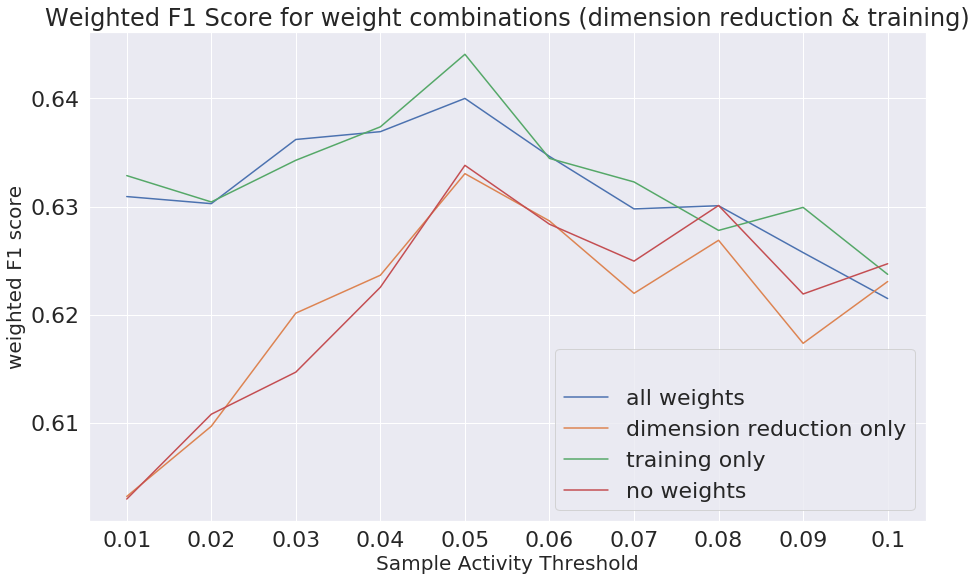

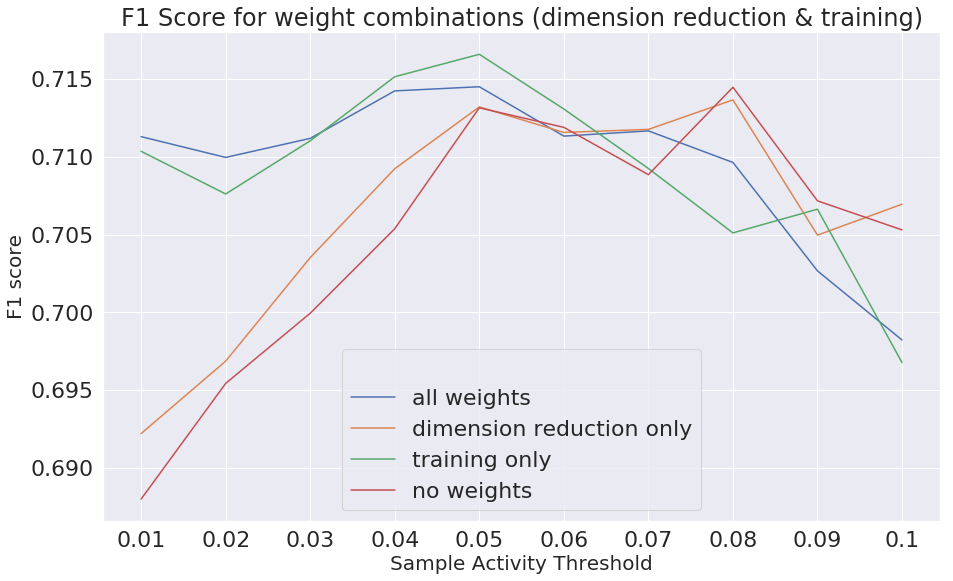

In [49]:
fig, ax = pyplot.subplots(figsize=(15, 9))
sns.set(font_scale=2)
ax = sns.lineplot(x="run_threshold", y="value", hue='variable', data=df_melt1)
ax.set_title('Weighted F1 Score for weight combinations (dimension reduction & training)')

rng = np.arange(0.01,0.11,0.01)
ax.set_xticks(rng)
ax.set_xticklabels([str(round(x, 2)) for x in rng])

ax.set_xlabel('Sample Activity Threshold',fontsize=20);
ax.set_ylabel('weighted F1 score',fontsize=20);
legend = ax.legend()
legend.texts[0].set_text("")

fig, ax = pyplot.subplots(figsize=(15, 9))
sns.set(font_scale=2)
ax = sns.lineplot(x="run_threshold", y="value", hue='variable', data=df_melt2)
ax.set_title('F1 Score for weight combinations (dimension reduction & training)')

ax.set_xticks(rng)
ax.set_xticklabels([str(round(x, 2)) for x in rng])

ax.set_xlabel('Sample Activity Threshold',fontsize=20);
ax.set_ylabel('F1 score',fontsize=20);
legend = ax.legend()
legend.texts[0].set_text("")